# Object Detection with Faster R-CNN
- Faster R-CNN을 이용해 물체인식 시도

In [1]:
import torch
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

## bbox 예시

In [2]:
image = torch.zeros((1,3,800,800))
image.size()

torch.Size([1, 3, 800, 800])

In [3]:
bbox = torch.FloatTensor([[20, 30, 400, 500], [300, 400, 500, 600]])
bbox

tensor([[ 20.,  30., 400., 500.],
        [300., 400., 500., 600.]])

In [4]:
np.array(bbox)

array([[ 20.,  30., 400., 500.],
       [300., 400., 500., 600.]], dtype=float32)

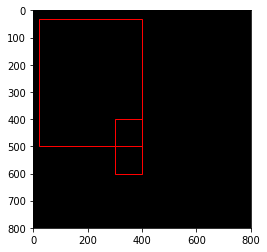

In [5]:
tensor = image
tensor = tensor.squeeze()
tensor = tensor.permute(1,2,0)
img = np.array(tensor)

fig, ax = plt.subplots()
ax.imshow(img)

import matplotlib.patches as patches
rect1 = patches.Rectangle((20,30),380,470, facecolor='none', edgecolor='r')
rect2 = patches.Rectangle((300,400),100,200, facecolor='none', edgecolor='r')

ax.add_patch(rect1)
ax.add_patch(rect2)

## Backbone -> VGG16
- inpput size == 800 
- output size == 800//16 = 50
- input과 output의 size를 위와 같도록 model 수정

In [6]:
# 확인을 위해 dummy image 생성
dummy_img = torch.zeros((1,3,800,800)).float()
dummy_img.size()

torch.Size([1, 3, 800, 800])

In [7]:
# VGG16 모델 아키텍처 보기
import torchvision

model_vgg16 = torchvision.models.vgg16(pretrained = True)

In [8]:
layer_list = list(model_vgg16.features)
layer_list

[Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
 Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
 Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
 Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 Conv2d(512, 512, kernel_size=(3, 3), stride=(1

In [9]:
dummy_img.size()

torch.Size([1, 3, 800, 800])

In [10]:
layer_list[0](dummy_img).size()

torch.Size([1, 64, 800, 800])

In [11]:
# output_size가 50이 될때까지 필요한 layer 
require_layers = []
for layer in layer_list:
    dummy_img = layer(dummy_img)
    if dummy_img.size()[2] < 800//16:
        break
    require_layers.append(layer)
    output_channel = dummy_img.size()[1]
    
print(output_channel)
print(len(require_layers))

512
30


In [12]:
import torch.nn as nn
faster_rcnn_feature_extractor = nn.Sequential(*require_layers)
faster_rcnn_feature_extractor

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

In [13]:
output_feature = faster_rcnn_feature_extractor(image)
print(output_feature.size())

torch.Size([1, 512, 50, 50])


## Generate Anchor box(방법 확인, 실제 만드는 건 뒤에)
- 각 비율, 크기마다 다른 anchor box 생성 -> 0.5, 1, 2 / 8, 16, 32
- 각 box는 x1,y1,x2,y2를 가지고 있음 -> size == (9,4)
- 1개의 feature map에 있는 1개의 픽셀에 대해 생성
> Now every pixel in the output feature map maps to corresponding 16 * 16 pixels in the image. This is shown in the below image<br>
-> 800x800에서 50x50으로 축소했으니 원본에서 16x16사이즈의 anchor box가 결국 feature map에서의 1개의 픽셀이 된다.

In [14]:
ratio = [0.5, 1, 2]
anchor_scales = [8,16,32]

anchor_base = np.zeros((len(ratio) * len(anchor_scales), 4))
anchor_base # feature map 1개의 픽셀에 대해 anchor box가 가질 수 있는 경우 9가지(비율3 x 크기3, x1 y1 x2 y2)

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

In [15]:
# anchor base 채우기
sub_sample = 16
ctr_x = sub_sample / 2
ctr_y = sub_sample / 2

for i in range(len(ratio)):
    for j in range(len(anchor_scales)):
        h = sub_sample * anchor_scales[j] * np.sqrt(ratio[i])
        w = sub_sample * anchor_scales[j] * np.sqrt(1/ratio[i])
        print(h,w)
        
        index = i * len(anchor_scales) + j
        print(index)
        
        anchor_base[index, 0] = ctr_y - h / 2
        anchor_base[index, 1] = ctr_x - w / 2
        anchor_base[index, 2] = ctr_y + h / 2
        anchor_base[index, 3] = ctr_x + w / 2
        
anchor_base
       

90.50966799187809 181.01933598375618
0
181.01933598375618 362.03867196751236
1
362.03867196751236 724.0773439350247
2
128.0 128.0
3
256.0 256.0
4
512.0 512.0
5
181.01933598375618 90.50966799187809
6
362.03867196751236 181.01933598375618
7
724.0773439350247 362.03867196751236
8


array([[ -37.254834  ,  -82.50966799,   53.254834  ,   98.50966799],
       [ -82.50966799, -173.01933598,   98.50966799,  189.01933598],
       [-173.01933598, -354.03867197,  189.01933598,  370.03867197],
       [ -56.        ,  -56.        ,   72.        ,   72.        ],
       [-120.        , -120.        ,  136.        ,  136.        ],
       [-248.        , -248.        ,  264.        ,  264.        ],
       [ -82.50966799,  -37.254834  ,   98.50966799,   53.254834  ],
       [-173.01933598,  -82.50966799,  189.01933598,   98.50966799],
       [-354.03867197, -173.01933598,  370.03867197,  189.01933598]])

**위 작업은 1개의 feature map에 대하여 생성한 anchor box**
- image 사이즈에서 벗어나거나 큰 anchor box는 negaitve values로 취급, 나중에 loss계산할 때 빼준다(-1로 바꿔줌)
- feature map이 50x50임으로 각 픽셀에 대해 anchor box 생성하면 -> 17500(50x50x9)<br>
(1개의 픽셀에 9가지의 anchor box 생성)

## feature map에 있는 모든 pixel에 대하여 anchor box 생성

### 모든 픽셀에 대한 센터값 모음 생성(ctr)

In [16]:
# 모든 픽셀에 대해 센터값(ctr_x, ctr_y) 생성

feature_size = 800//16
ctr_x = np.arange(16, (feature_size+1)*16, 16) # image 원본에서의 센터값x
ctr_y = np.arange(16, (feature_size+1)*16, 16) # image 원본에서의 센터값y

index = 0
ctr = np.zeros((len(ctr_x) * len(ctr_y), 2))
for x in range(len(ctr_x)):
    for y in range(len(ctr_y)):
        ctr[index, 1] = ctr_x[x] - 8
        ctr[index, 0] = ctr_y[y] - 8
        index += 1
        
ctr.shape # 1개의 image에 대한 모든 anchor box의 중심점의 모음

(2500, 2)

### 각 센터값에 대당하는 anchor box 생성(위와 다르게 실제로 생성)
- 1개의 feature map에 해당하는 모든 anchor box 생성

In [17]:
anchors = np.zeros((feature_size * feature_size * 9, 4)) # 각 anchor box에 대한 y1, x1, y2, x2
sub_sample = 16
index = 0
for c in ctr: # y,x
    ctr_y, ctr_x = c
    for i in range(len(ratio)):
        for j in range(len(anchor_scales)):
            h = sub_sample * anchor_scales[j] * np.sqrt(ratio[i])
            w = sub_sample * anchor_scales[j] * np.sqrt(1/ratio[i])
            
            anchors[index, 0] = ctr_y - h/2 # y1
            anchors[index, 1] = ctr_x - w/2 # x1
            anchors[index, 2] = ctr_y + h/2 # y2
            anchors[index, 3] = ctr_x + w/2 # x2
            index += 1
print(anchors.shape)

(22500, 4)


## 모든 Anchor box에 Labels과 location 할당하기
**두 종류의 Anchor에는 'Positive label'을 할당**
1. 정답(Ground-Truth)과 비교했을 때 IOU(Intersection-over-Union)값이 가장 큰 Anchor/Anchors
2. 정답(Ground-Truth)과 비교했을 때 IOU(Intersection-over-Union)값이 **0.7** 이상일 때
> **Object가 1개에 대하여 여러 Anchor box에 Positive label을 할당하는 경우가 있다.**

**아래와 같은 Anchor에는 'Negative label'을 할당**
1. 정답(Ground-Truth)과 비교했을 때 IOU(Intersection-over-Union)값이 **0.3**보다 작을 때


In [18]:
# 예시 Ground-Truth값(정답값 2개 objects)
bbox = np.asarray([[20, 30, 400, 500], [300, 400, 500, 600]], dtype=np.float32) # y1, x1, y2, x2
labels = np.asarray([6, 8], dtype=np.int8) # 0값은 배경을 나타냄

### 유효한(valid) Anchor box의 index 찾기
- Anchor box가 image보다 크거나 범위에서 벗어나면 유효하지 않음
- 즉, Anchor box의 x1 y1 x2 y2 값들이 모두 0~800 사이에 있어야 유효한 box

In [19]:
index_inside = np.where((anchors[:,0] >= 0) &
                        (anchors[:,1] >= 0) &
                        (anchors[:,2] <= 800) &
                        (anchors[:,3] <= 800))[0]
print(index_inside.shape)
print(anchors[index_inside[0]])

(8940,)
[ 13.49033201  10.745166   194.50966799 101.254834  ]


### Label 행렬 만들기
- 여기서 label은 물체가 있는지 없는지(objectness)만 판별
- 따라서 1또는 -1로 표시(1은 물체가 있고 -1은 background)
- 각 anchor box별로 물체 유무에 따라 1 or -1
> **유효한 Anchor box 개수 = label 행렬 크기**

In [20]:
label = np.empty_like(index_inside)
label.fill(-1)
label.shape

(8940,)

### 유효한 Anchor box 추출

In [21]:
valid_anchor_boxes = anchors[index_inside]
valid_anchor_boxes.shape

(8940, 4)

### IOU 계산
- 위에서 임의로 정의한 bbox를 정답(Ground-Truth)이라고 가정

In [22]:
ious = np.zeros((len(valid_anchor_boxes), 2)) # 각 Anchor box와 Ground-Truth와의 IOU 값

for num1, i in enumerate(valid_anchor_boxes):
    ya1, xa1, ya2, xa2 = i
    anchor_area = (ya2-ya1) * (xa2-xa1)
    for num2, j in enumerate(bbox):
        yb1, xb1, yb2, xb2 = j
        box_area = (yb2-yb1) * (xb2-xb1)
        
        inter_x1 = max([xa1, xb1])
        inter_y1 = max([ya1, yb1])
        inter_x2 = min([xa2, xb2])
        inter_y2 = min([ya2, yb2])
        
        if (inter_x1 < inter_x2) and (inter_y1 < inter_y2):
            inter_area = (inter_y2 - inter_y1) * (inter_x2 - inter_x1)
            iou = inter_area/(box_area + anchor_area - inter_area) # inter_area가 반복됨으로 한 번 빼준다.
            
        else:
            iou = 0
            
        ious[num1, num2] = iou # 각각의 Anchor box에 대한 2 objects의 iou 값
        
ious.shape

(8940, 2)

### 조건에 만족하는 IOU값 및 그 값에 해당하는 Anchor box 선별
1. 2개의 Ground-Truth box에 대하여 가장 큰 IOU값과 그 값(2개의 Ground-Truth box)에 해당하는 Anchor box
2. 각각의 Anchor box 에서 가장 큰 IOU값과 그 값에 해당하는 Ground-Truth box

#### 1. 각 Object에 대해 가장 큰 IOU 값과 각 해당하는 Anchor box index

In [23]:
gt_argmax_ious = ious.argmax(axis = 0)
gt_argmax_ious

array([2262, 5620], dtype=int64)

In [24]:
ious[gt_argmax_ious]

array([[0.68130493, 0.08628624],
       [0.10757449, 0.61035156]])

In [25]:
gt_max_ious = ious[gt_argmax_ious, np.arange(ious.shape[1])] # (0,0) , (1,1)
gt_max_ious

array([0.68130493, 0.61035156])

#### 2.  각 Object(2개)에 대한 Anchor box(2개) 중 IOU가 큰 Anchor box(2 중 하나)

In [26]:
argmax_ious = ious.argmax(axis = 1)
print(argmax_ious.shape)
print(argmax_ious) # 2개 중 1개의 index가 나오겟죠? 

(8940,)
[0 0 0 ... 0 0 0]


In [27]:
# index_inside == 유효한 Anchro box의 index
max_ious = ious[np.arange(len(index_inside)), argmax_ious] # 유효한 Anchor box 중 IOU 값이 큰 box(2중 더 큰 값)
print(max_ious)

[0.06811669 0.07083762 0.07083762 ... 0.         0.         0.        ]


### 가장 큰 IOU값을 가지고 있는 Anchor box 찾기
- 저 결과값들은 Anchor box들 중 IOU가 가장 큰 Anchor box들

In [28]:
gt_argmax_ious = np.where(ious == gt_max_ious)[0]
print(gt_argmax_ious)

[2262 2508 5620 5628 5636 5644 5866 5874 5882 5890 6112 6120 6128 6136
 6358 6366 6374 6382]


### 우리는 3가지의 결과를 얻었다.
1. argmax_ious : 각 Anchor 중 어느 Object에 대한 IOU가 큰 값인지 나타낸 index(0 or 1)
2. max_ious : 각 Anchro에 대하여 두 Ojbect 중 IOU가 더 큰 Object에 해당하는 IOU
3. gt_argmax_ious : 가장 큰 IOU값을 지니고 있는 Anchor box들의 index

In [29]:
argmax_ious

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [30]:
max_ious

array([0.06811669, 0.07083762, 0.07083762, ..., 0.        , 0.        ,
       0.        ])

In [31]:
gt_argmax_ious

array([2262, 2508, 5620, 5628, 5636, 5644, 5866, 5874, 5882, 5890, 6112,
       6120, 6128, 6136, 6358, 6366, 6374, 6382], dtype=int64)

### 임계값 설정

In [32]:
pos_iou_threshold = 0.7 # IOU값이 0.7를 넘으면 positive
neg_iou_threshold = 0.3 # IOU값이 0.3 아래면 negative

In [33]:
label[max_ious < neg_iou_threshold] = 0 # Negative label에 0 설정
label[gt_argmax_ious] = 1 # Ojbect와 비교했을 때 IOU가 가장 높은 Anchor box에 1 할당
label[max_ious >= pos_iou_threshold] = 1 # IOU가 0.7 이상인 Anchor box 1 할당

## RPN(Regions Proposal Network) 학습을 위한 Target 만들기
각 싱글 이미지로부터 나온 Mini-Batch(pos와 neg anchor를 포함한)를 이용하여 Target읆 만든다.
- 256개의 Anchor box를 랜덤하게 샘플링한다 -> mini batch의 Loss를 계산할 때 사용
- pos와 neg의 비율은 1:1이다.
- **결과로 만들어진 Target이 예측값이고, 정답과 비교해서 loss를 계산한다 <- 학습의 목표**

In [34]:
pos_ratio = 0.5
n_sample = 256

n_pos = pos_ratio * n_sample

### positive label에서 n_pos 랜덤하게 샘플링
- 만약 n_pos개보다 적게 샘플링한다면 negative samples를 랜덤하게 샘플링

In [35]:
pos_index = np.where(label == 1)[0]
pos_index

array([2262, 2508, 5620, 5628, 5636, 5644, 5866, 5874, 5882, 5890, 6112,
       6120, 6128, 6136, 6358, 6366, 6374, 6382], dtype=int64)

#### 1. Positive Samples

In [36]:
if len(pos_index) > n_pos:
    disable_index = np.random.choice(pos_index, size=(len(pos_index) - n_pos), replace = False)
    label[disable_index] = -1

#### 2. Negative Samples

In [37]:
n_neg = n_sample * np.sum(label == 1)
neg_index = np.where(label == 0)[0]

if len(neg_index) > n_neg:
    disable_index = np.random.choice(neg_index, size=(len(neg_index) - n_neg), replace = False)
    label[disable_index] = -1

### Loss Function 정의
Bounding-Box Regression을 이용하여 손실함수 정의<br>
![사진-벡터로 변환하는](https://i.imgur.com/1jTnrMG.png)
- x,y,w,h는 센터(x,y)와  가로, 세로
- x_a, y_a, h_a, w_a는 Anchor box의 센터(x,y)와 가로, 세로

In [38]:
max_iou_bbox = bbox[argmax_ious]
max_iou_bbox

array([[ 20.,  30., 400., 500.],
       [ 20.,  30., 400., 500.],
       [ 20.,  30., 400., 500.],
       ...,
       [ 20.,  30., 400., 500.],
       [ 20.,  30., 400., 500.],
       [ 20.,  30., 400., 500.]], dtype=float32)

In [39]:
valid_anchor_boxes # y1, x1, y2, x2

array([[ 13.49033201,  10.745166  , 194.50966799, 101.254834  ],
       [ 29.49033201,  10.745166  , 210.50966799, 101.254834  ],
       [ 45.49033201,  10.745166  , 226.50966799, 101.254834  ],
       ...,
       [573.49033201, 698.745166  , 754.50966799, 789.254834  ],
       [589.49033201, 698.745166  , 770.50966799, 789.254834  ],
       [605.49033201, 698.745166  , 786.50966799, 789.254834  ]])

#### 유효한 Anchor box들의 좌표를 '중앙값(x,y)과 가로, 세로'로 변환

In [40]:
height = valid_anchor_boxes[:, 2] - valid_anchor_boxes[:,0] # y2 - y1
width = valid_anchor_boxes[:,3] - valid_anchor_boxes[:,1] # x2 - x1
ctr_y = valid_anchor_boxes[:, 0] + 0.5*height # y의 중앙값
ctr_x = valid_anchor_boxes[:, 1] + 0.5*width # x의 중앙값

# 2개의 Object 중 각 Anchor box와의 IOU값이 더 큰 Object의 box == max_iou_bbox
base_height = max_iou_bbox[:,2] - max_iou_bbox[:,0]
base_width = max_iou_bbox[:,3] - max_iou_bbox[:,1]
base_ctr_y = max_iou_bbox[:,0] + 0.5*base_height
base_ctr_x = max_iou_bbox[:,1] + 0.5*base_width

In [41]:
eps = np.finfo(height.dtype).eps # finfo : float에 대한 정보, eps : 표현 가능한 가장 작은 수
height = np.maximum(height, eps)
width = np.maximum(width, eps)

dy = (base_ctr_y - ctr_y) / height
dx = (base_ctr_x - ctr_x) / width
dh = np.log(base_height / height)
dw = np.log(base_width / width)

In [42]:
anchor_locs = np.vstack((dy, dx, dh, dw)).transpose() # y, x, h, w
anchor_locs # 유효한 Anchors box의 좌료를 중심+가로+세로 좌표로 변환

array([[ 0.5855728 ,  2.30914558,  0.7415674 ,  1.64727602],
       [ 0.49718446,  2.30914558,  0.7415674 ,  1.64727602],
       [ 0.40879611,  2.30914558,  0.7415674 ,  1.64727602],
       ...,
       [-2.50801936, -5.29225232,  0.7415674 ,  1.64727602],
       [-2.59640771, -5.29225232,  0.7415674 ,  1.64727602],
       [-2.68479606, -5.29225232,  0.7415674 ,  1.64727602]])

### 최종 Labels
1. **index_inside** : IOU상관 없이 object 안에 들어가 있는 Anchor (8940개)


2. **anchor_labels** : 만들어진 모든 anchors박스에 대한 label
 - object 와 하나도 안 겹치는 부분은 배경으로 간주, -1
 - IOU가 0.3 이하인 Anchor는 -1 
 - IOU가 0.7 이상이거나 가장 큰 anchor는 1
 - 둘 다 아닌 anchor는 0 -> 무시

 
3. **anchor_labels[index_inside]** : 1또는 

In [43]:
anchor_labels = np.empty((len(anchors)), dtype = label.dtype) # 
anchor_labels.fill(-1)
anchor_labels[index_inside] = label
anchor_labels # [22500]

array([-1, -1, -1, ..., -1, -1, -1], dtype=int64)

### 최종 Anchor box의 Location
위에 최종 Labels와 비슷한 내용

In [44]:
anchor_locations = np.empty(anchors.shape, dtype=anchor_locs.dtype)
anchor_locations.fill(0)
anchor_locations[index_inside, :] = anchor_locs
anchor_locations  # [22500, 4]

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

> 위에 만들어진 최종 Location과 Labels는 RPN network의 Target으로 쓰인다<br>
**Target을 정답과 비교해 알맞게 바꾸는 Transform을 찾아내는 것이 학습의 목표!!**

## Region Proposal Network 만들기
과거의 모델들은 Selective search, CPMC, MCG 등의 알고리즘을 통해 Region Proposal을 생성했다.<br>
Faster R-CNN부터는 이 과정을 deep learning으로 만들었다.
- Backbone이었던 VGG16모델을 거친 마지막 feature map을 사용(50x50 size)
- nxn size의 Fliter가 slide하면서 각 pixel마다 9개의 region proposals을 예측(여기서는 n=3)
- 가로:세로 비율이 (0.5:1, 1:1, 1:0.5)
- 1:1기준으로 region propsoal의 크기는 16x16
- 50x50 size feature map의 1픽셀 당 원본크기는 16x16(원본 800x800에서 50x50으로 작아졌기 때문에 16:1)
- 50x50 size feature map은 512 features, RPN의 결과는 256 features
- 2개의 Layer로 찢어진다
 - Box Regression Layer : 박스를 예측하는 layer
 - Box Classification Layer : 박스 안에 물체가 있는지 없는지(물체인지 배경인지, -1 또는 1)

#### Slide Window, Regression Layer, Classification Layer 생성

In [45]:
## n=3인 slide window 이용
import torch.nn as nn
mid_channels = 256
in_channels = 512 # vgg16 결과가 512
n_anchor = 9 # 각 location마다 생성되는 anchor의 개수
conv1 = nn.Conv2d(in_channels, mid_channels, 3, stride = 1, padding = 1)
reg_layer = nn.Conv2d(mid_channels, n_anchor * 4, 1, stride = 1, padding = 0) # 1d Conv2d
cls_layer = nn.Conv2d(mid_channels, n_anchor * 2, 1, stride = 1, padding = 0) # SoftMax함수를 이용할 예정

논문에 의하면 conv레이어의 가중치를 zero mean과 0.01 standard deviation로 했다고 되어있음

In [46]:
# Slide Window layer
conv1.weight.data.normal_(0, 0.01)
conv1.bias.data.zero_()

# Regression layer
reg_layer.weight.data.normal_(0, 0.01)
reg_layer.bias.data.zero_()

# Classification layer
cls_layer.weight.data.normal_(0, 0.01)
cls_layer.bias.data.zero_()

for lay in [conv1, reg_layer, cls_layer]:
    print(lay.weight.shape)

torch.Size([256, 512, 3, 3])
torch.Size([36, 256, 1, 1])
torch.Size([18, 256, 1, 1])


#### Vgg16 결과 전달
- Backbone의 결과 feature map을 RPN Network로 전달(output_feature)
- 이후 각각 reg, cls layer을 거쳐서 box와 objectness 예측

In [47]:
x = conv1(output_feature)
pred_anchor_locs = reg_layer(x)
pred_cls_scores = cls_layer(x)

print(pred_anchor_locs.shape, pred_cls_scores.shape)

torch.Size([1, 36, 50, 50]) torch.Size([1, 18, 50, 50])


#### RPN Network & ROI Network
1. RPN Network
 - Pred_cls_scores
 - Pred_anchor_locs

2. ROI Network(Proposal layer)
 - Pred_cls_scores
 - objectness_scores

In [49]:
# contiguous는 텐서를 메모리상에 일렬로 정렬해주는 역할
pred_anchor_locs = pred_anchor_locs.permute(0,2,3,1).contiguous().view(1, -1, 4)
print(pred_anchor_locs.shape)

pred_cls_scores = pred_cls_scores.permute(0,2,3,1).contiguous()
print(pred_cls_scores.shape)

objectness_score = pred_cls_scores.view(1, 50, 50, 9, 2)[:,:,:,:,1].contiguous().view(1, -1)
print(objectness_score.shape)

pred_cls_scores = pred_cls_scores.view(1, -1, 2)
print(pred_cls_scores.shape)

torch.Size([1, 22500, 4])
torch.Size([1, 50, 50, 18])
torch.Size([1, 22500])
torch.Size([1, 22500, 2])


## Proposals 생성하기
여러 ratio(0.5:1, 1:1, 1:0.5)로 생성된 proposal들은 겹치는 부분이 많다.<br>
따라서 NMS(Non-Maximum Supression)을 이용해 반복되는 proposal을 제거해준다.
- cls score을 기준으로 NMS 적용
- NMS에서 사용할 IOU의 threshold는 0.7로 고정 -> 1개의 image당 약 2000개의 proposal 생성
- NMS의 결과 중 top-N 랭크된 결과들만 detection에 사용한다.
- testing을 한 대는 약 300개의 proposal들이 사용된다.(논문에 많은 실험을 통해 저 수치가 적당...)

In [50]:
nms_thresh = 0.7 # IOU 0.7이상인 것은 제거
n_train_pre_nms = 12000
n_train_post_nms = 2000
n_test_pre_nms = 6000
n_test_post_nms = 300
min_size = 16

### Proposals 만들어지는 과정
1. RPN Network의 결과인 predicted box를 bbox(y1, x1, y2, x2)로 변환
2. Predicted box를 image에 clip
3. Height또는 Width가 Threshold(min_size, 16)보다 작으면 해당 predicted box 제거
4. 모든 (Proposal, score) 쌍을 score을 기준으로 내림차순으로 정렬
 - 여기서 score는 objectness의 점수
5. 상위 N개의 Proposal만 취한다.
 - Training 시 12000개(n_train_pre_nms)
 - Testing 시 300개(n_test_post_nms)
6. IOU의 threshold(0.7)을 적용
 - 가장 높은 Score을 가진 Proposal 1개와 나머지 Proposal을 전부 비교
 - 그 중 IOU값이 0.7이상 나오는 box들은 top score Proposal과 같은 물체로 판단
 - 따라서 0.7이상 나오는 box들은 전부 제거
7. 6번을 통해 나온 결과 중 상위 N개의 Proposal만 취한다.
 - Training 시 2000개(n_train_post_nms)
 - Testing 시 300개(n_test_post_nms)

#### 1. RPN Network의 결과인 Predicted box 변환
(y_cen, x_cen, h, w) -> (y1, x1, y2, x2) 